# Lesson 6: pets revisited

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

from ipyexperiments import *
exp1 = IPyExperimentsPytorch()


# w/o fixing random memory usage patterns change wildly and it's hard to tune things up this way
if True:
    import torch
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(42)
    random.seed(42)
    np.random.seed(42)


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1070 Ti (8119 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  1856 19730  31588 MB   5.88% 
GPU:   427  7692   8119 MB   5.26% 




･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.015
･ CPU:         0       0     1857 MB |
･ GPU:         0       0      427 MB |


In [ ]:
bs = 64

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     1857 MB |
･ GPU:         0       0      427 MB |


In [ ]:
path = untar_data(URLs.PETS)/'images'

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.030
･ CPU:         0       1     1858 MB |
･ GPU:         0       0      427 MB |


## Data augmentation

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.011
･ CPU:         0       0     1858 MB |
･ GPU:         0       0      427 MB |


In [ ]:
#doc(get_transforms)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.027
･ CPU:         0       0     1858 MB |
･ GPU:         0       0      427 MB |


In [ ]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.075
･ CPU:         2       0     1865 MB |
･ GPU:         0       0      427 MB |


In [ ]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     1865 MB |
･ GPU:         0       0      427 MB |


In [ ]:
data = get_data(224, bs, 'zeros')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.520
･ CPU:         1       3     1935 MB |
･ GPU:         0       0      427 MB |


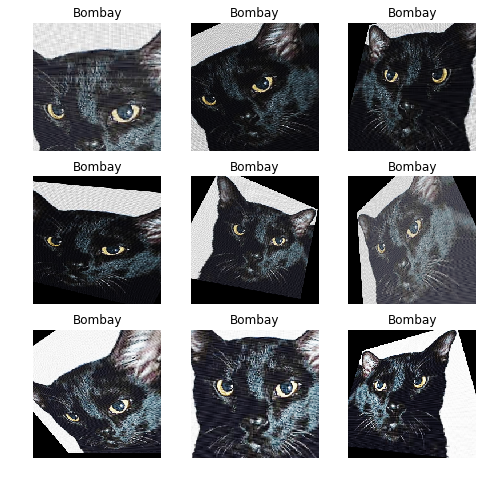

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.470
･ CPU:         0       9     1938 MB |
･ GPU:         0       0      427 MB |


In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
data = get_data(224,bs)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.443
･ CPU:         0       3     1940 MB |
･ GPU:         0       0      427 MB |


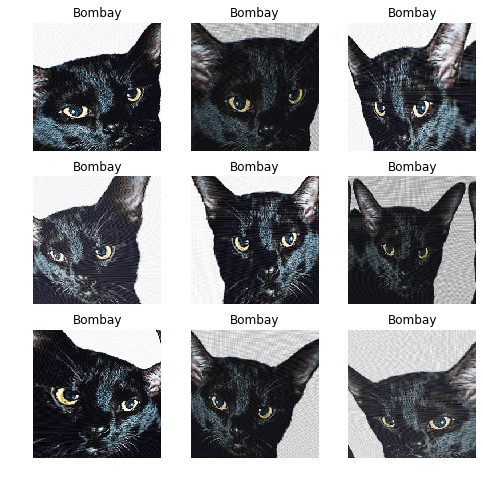

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.441
･ CPU:         0      10     1940 MB |
･ GPU:         0       0      427 MB |


In [ ]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [ ]:
# this is for bs tune up - it will run through fit calls really fast, doing the minimum required to setup gpu requirements

class FitNBatch(Callback):
    def __init__(self, n_batch:int=2): 
        print("init")
        self.stop,self.n_batch = False,n_batch
        
    def on_batch_end(self, iteration, **kwargs):
        if iteration >= self.n_batch: self.stop = True
        print("batch end")
        return self.stop

    def on_epoch_end(self, **kwargs): 
        print("epoch end")
        return self.stop


# True turns the speedup on, False return to normal behavior
tune = True
if tune:
    defaults.extra_callbacks = [FitNBatch()]
else:
    defaults.extra_callbacks = None


init
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.002
･ CPU:         0       0     1940 MB |
･ GPU:         0       0      427 MB |


In [ ]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

0

creating 8 hooks@@@@
removing 8 hooks@@@@
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.513
･ CPU:         0       0     2073 MB |
･ GPU:       112       0      539 MB |


In [ ]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate


batch end
batch end
batch end
batch end
epoch end
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:05.939
･ CPU:         0       0     2066 MB |
･ GPU:       110    3428      649 MB |


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate


batch end
batch end
epoch end
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:05.351
･ CPU:         0       0     2066 MB |
･ GPU:       466    2254     1115 MB |


In [ ]:

data = get_data(352,bs)
learn.data = data

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.716
･ CPU:         0       3     2190 MB |
･ GPU:         0       0     1115 MB |


In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate


batch end
batch end
epoch end
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:08.975
･ CPU:         0       0     2190 MB |
･ GPU:         0    6224     1115 MB |


In [ ]:
learn.save('352')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.293
･ CPU:         0       0     2190 MB |
･ GPU:         0       0     1115 MB |


## Convolution kernel

In [ ]:
data = get_data(352,16)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.226
･ CPU:         0       3     2191 MB |
･ GPU:         0       0     1115 MB |


In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

creating 8 hooks@@@@
removing 8 hooks@@@@
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.775
･ CPU:         1       1     2159 MB |
･ GPU:      -320     604      795 MB |


Category newfoundland

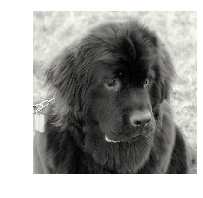

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.081
･ CPU:         0       4     2159 MB |
･ GPU:         0       0      795 MB |


In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2159 MB |
･ GPU:         0       0      795 MB |


In [ ]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.051
･ CPU:         0       0     2159 MB |
･ GPU:         0       0      795 MB |


In [ ]:
k.shape

torch.Size([1, 3, 3, 3])

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2159 MB |
･ GPU:         0       0      795 MB |


In [ ]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.007
･ CPU:         0       3     2159 MB |
･ GPU:         0       0      795 MB |


In [ ]:
t[None].shape

torch.Size([1, 3, 352, 352])

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2159 MB |
･ GPU:         0       0      795 MB |


In [ ]:
edge = F.conv2d(t[None], k)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.030
･ CPU:         0       0     2160 MB |
･ GPU:         0       0      795 MB |


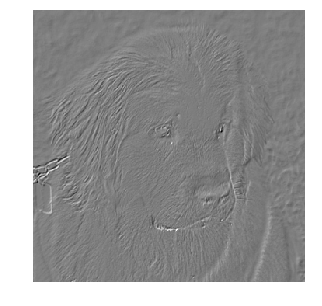

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.092
･ CPU:         0       2     2160 MB |
･ GPU:         0       0      795 MB |


In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
data.c

37

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2160 MB |
･ GPU:         0       0      795 MB |


In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.005
･ CPU:         0       0     2160 MB |
･ GPU:         0       0      795 MB |


In [ ]:
print(learn.summary())

△used: 0MB, △peaked: 0MB: sum 1
creating 101 hooks@@@@
creating 101 hooks@@@@
removing 101 hooks@@@@
removing 101 hooks@@@@
△used: 0MB, △peaked: 0MB: sum 2
△used: 0MB, △peaked: 0MB: sum end
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 176, 176]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 176, 176]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 176, 176]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 88, 88]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 88, 88]      36,864     False     
______________________________________________________________________
BatchNorm2d          [1, 64, 88, 88]      128        True      
_______

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:01.673
･ CPU:         0       0     2160 MB |
･ GPU:         0    1094      795 MB |


## Heatmap

In [ ]:
m = learn.model.eval();

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2160 MB |
･ GPU:         0       0      795 MB |


In [ ]:
xb,_ = data.one_item(x)
xb, xb.shape
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()


(tensor([[[[1.6121, 1.5894, 1.5705,  ..., 1.9215, 1.8861, 1.8722],
           [1.6185, 1.5690, 1.5365,  ..., 1.9294, 1.9219, 1.9157],
           [1.5485, 1.5228, 1.5312,  ..., 1.9424, 1.9429, 1.9298],
           ...,
           [0.9442, 1.0296, 0.9802,  ..., 0.6236, 0.4779, 0.3805],
           [0.8419, 0.9800, 0.9925,  ..., 0.5756, 0.4025, 0.0804],
           [1.0442, 1.0791, 1.0075,  ..., 0.4876, 0.2354, 0.2363]],
 
          [[1.7951, 1.7718, 1.7525,  ..., 2.1114, 2.0752, 2.0609],
           [1.8016, 1.7510, 1.7177,  ..., 2.1195, 2.1117, 2.1054],
           [1.7300, 1.7038, 1.7124,  ..., 2.1327, 2.1333, 2.1199],
           ...,
           [1.0772, 1.1645, 1.1141,  ..., 0.7566, 0.6321, 0.5360],
           [0.9726, 1.1139, 1.1266,  ..., 0.7013, 0.5470, 0.2292],
           [1.1794, 1.2152, 1.1419,  ..., 0.6317, 0.3876, 0.3886]],
 
          [[1.8699, 1.8467, 1.8275,  ..., 2.1848, 2.1488, 2.1346],
           [1.8764, 1.8260, 1.7929,  ..., 2.1929, 2.1851, 2.1788],
           [1.8051, 1.77

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.080
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
from fastai.callbacks.hooks import *

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
def hooked_backward2(cat=y):
    with hook_output(m[0]) as hook_a: 
        
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a

hook_a = hooked_backward2()
acts  = hook_a.stored[0].cpu()
acts.shape
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([512, 11, 11])

torch.Size([11, 11])

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.204
･ CPU:         0       0     2162 MB |
･ GPU:         0    1094      795 MB |


In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
hook_a,hook_g = hooked_backward()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.046
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    #xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


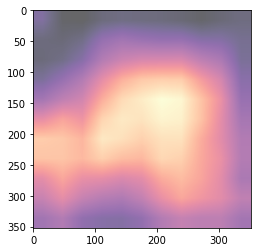

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.230
･ CPU:         0       1     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.002
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


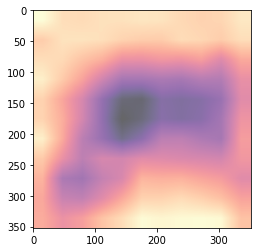

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.159
･ CPU:         0       1     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


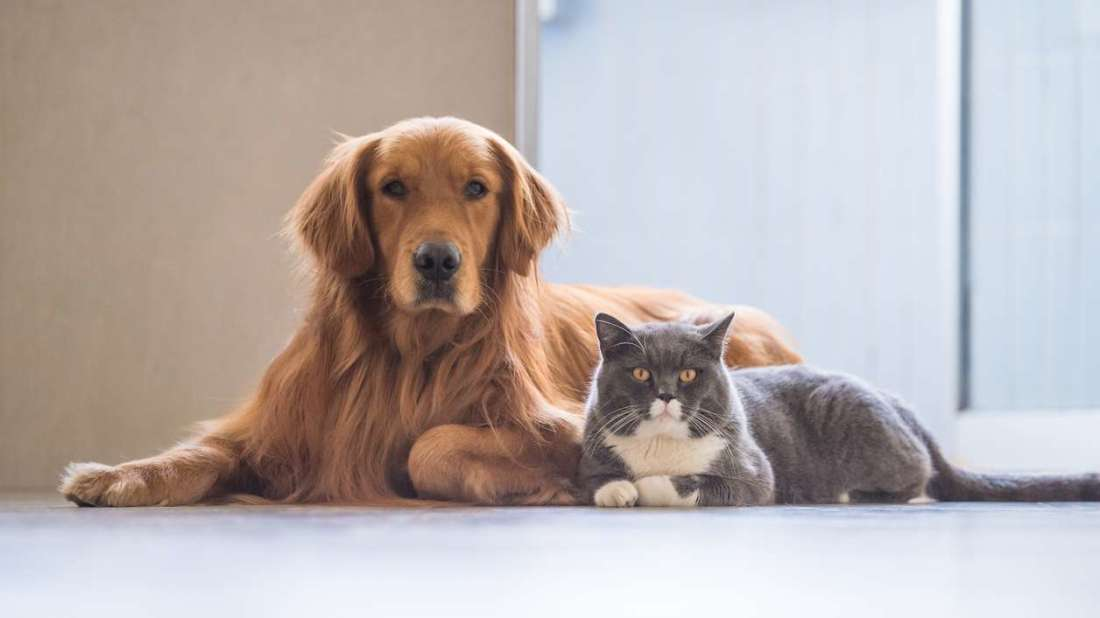

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.189
･ CPU:         8      41     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.012
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
hook_a,hook_g = hooked_backward()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.045
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.386
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


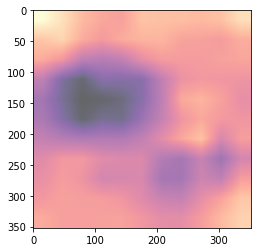

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.482
･ CPU:         0       1     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'Abyssinian'

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
hook_a,hook_g = hooked_backward(0)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.036
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     2162 MB |
･ GPU:         0       0      795 MB |


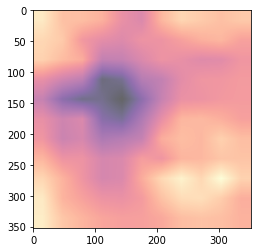

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.145
･ CPU:         0       1     2162 MB |
･ GPU:         0       0      795 MB |


In [ ]:
show_heatmap(mult)

## fin